In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
%matplotlib inline

#plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

In [116]:
eventos_raw = pd.read_csv('data/events.csv', low_memory = False)

In [117]:
eventos_raw.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Paid,New,Camaragibe,Pernambuco,Brazil,Smartphone,360x640,Android 6,Chrome Mobile 39
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
eventos_raw.shape

(1011288, 23)

In [119]:
eventos_raw.columns

Index(['timestamp', 'event', 'person', 'url', 'sku', 'model', 'condition',
       'storage', 'color', 'skus', 'search_term', 'staticpage',
       'campaign_source', 'search_engine', 'channel', 'new_vs_returning',
       'city', 'region', 'country', 'device_type', 'screen_resolution',
       'operating_system_version', 'browser_version'],
      dtype='object')

In [120]:
eventos_raw.describe()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
count,1011288,1011288,1011288,82756,563838,564284,563836,563836,563836,221699,...,50957,87378,87378,87378,87378,87378,87378,87378,87378,87378
unique,793805,11,27624,227,3574,202,5,8,63,35310,...,4,7,2,1939,93,46,4,282,121,343
top,2018-05-15 15:56:06,viewed product,71492f2b,/,2830.0,iPhone 6,Bom,16GB,Preto,"2820,6706,6720,2750,6649,7251,6663,12604,7224,...",...,Google,Paid,Returning,Unknown,Sao Paulo,Brazil,Smartphone,360x640,Windows 7,Chrome 66.0
freq,11,528931,2771,28323,4282,50916,243014,190833,132960,594,...,50240,44193,60480,15819,24996,84308,44239,30009,19675,22611


# Análisis de la presencia de NANS

In [121]:
eventos_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011288 entries, 0 to 1011287
Data columns (total 23 columns):
timestamp                   1011288 non-null object
event                       1011288 non-null object
person                      1011288 non-null object
url                         82756 non-null object
sku                         563838 non-null object
model                       564284 non-null object
condition                   563836 non-null object
storage                     563836 non-null object
color                       563836 non-null object
skus                        221699 non-null object
search_term                 48967 non-null object
staticpage                  3598 non-null object
campaign_source             82796 non-null object
search_engine               50957 non-null object
channel                     87378 non-null object
new_vs_returning            87378 non-null object
city                        87378 non-null object
region                    

Con lo que nos tira el info  podemos ver que hay algunas columnas que no tienen ningún NAN, estas son:
    
- timestamp
- event
- person
    
Tiene sentido que ninguna tenga ningún NAN, ya que en todos los casos corresponde tener esa información.

Ahora, veamos las columnas que tienen alguna densidad de NAN. En principio puede haber NANs porque esa
información no corresponde, podemos pensar que el tipo de evento es el que define qué valores
corresponden y cuales no. Recordemos los tipos de eventos que teníamos:

In [122]:
eventos_raw.event.value_counts()

viewed product       528931
brand listing         98635
visited site          87378
ad campaign hit       82827
generic listing       67534
searched products     56073
search engine hit     50957
checkout              33735
staticpage             3598
conversion             1172
lead                    448
Name: event, dtype: int64

Por ejemplo, vemos que tenemos 50957 eventos que corresponden al _search engine hit_ y viendo devuelta
lo que obtuvimos con `info()` también podemos apreciar que hay en la columna de _search_engine_ la 
misma cantidad de no NANs. Esto se corresponde con lo que habíamos pensado de que a determinados
eventos le corresponden determinada información, y por eso en este caso en todas las demás entradas habría NANs,
ya que realmente no corresponde.

Estudiemos más a fondo esto. Primero veamos correspondencias entre _event_ y la información en ciertas columnas.

## Correspondencia _event_-información

In [123]:
# Saco las columnas que no me interesan.
filtered = eventos_raw.drop(['timestamp','person'], axis='columns')

In [124]:
def columnas_sin_nans_para_event(dataframe, event):
    return dataframe.loc[dataframe.event == event].iloc[0].dropna().index

In [125]:
# Vemos las columnas que tienen información (ningún NAN) para cada tipo de evento

for event in eventos_raw.event.unique():
    print(event + ': ' + str(list(columnas_sin_nans_para_event(filtered, event).drop('event'))))

ad campaign hit: ['url', 'campaign_source']
visited site: ['channel', 'new_vs_returning', 'city', 'region', 'country', 'device_type', 'screen_resolution', 'operating_system_version', 'browser_version']
viewed product: ['sku', 'model', 'condition', 'storage', 'color']
checkout: ['sku', 'model', 'condition', 'storage', 'color']
generic listing: ['skus']
search engine hit: ['search_engine']
brand listing: ['skus']
searched products: ['skus', 'search_term']
conversion: ['sku', 'model', 'condition', 'storage', 'color']
staticpage: ['staticpage']
lead: ['model']


- [ ] TODO: ver una forma más linda y más "pandezca" de filtrar esta información y de mostrarla.

Vemos que para cada evento tenemos cierta información que tiene sentido tener y cierta que no. De ahí
varios NANs que nos aparecen en algunas columnas.

Pero ahora veamos si todos los NANs en las columnas son porque no corresponde tener esa info para el 
evento o si hay alguna clase de "fuga" de NANs donde sí corresponde tener la información.

- [ ] TODO: hacer lo que digo que voy a hacer en el anterior párrafo. Me retiro a estudiar otra cosa. (?)

In [126]:
eventos_raw.timestamp.value_counts().head()

2018-05-15 15:56:06    11
2018-06-05 14:23:13     9
2018-06-14 15:43:38     9
2018-05-30 21:14:12     9
2018-06-15 14:05:11     9
Name: timestamp, dtype: int64

In [127]:
# Quiero ver si hay algún nan
print("Cantidad de nans: " + str(eventos_raw.timestamp.size - eventos_raw.timestamp.count()))

Cantidad de nans: 0


In [128]:
eventos_raw.event.value_counts()

viewed product       528931
brand listing         98635
visited site          87378
ad campaign hit       82827
generic listing       67534
searched products     56073
search engine hit     50957
checkout              33735
staticpage             3598
conversion             1172
lead                    448
Name: event, dtype: int64

In [129]:
# Hay varios Unknown, sería interesante ver si les corresponden alguna city conocida (si supieramos la 
# ciudad podríamos ver qué país realmente es) o Unknowns (no podríamos definir país) también.

# Por otra parte vemos que tenemos la gran mayoría de es de Brasil, tener en cuenta a la hora 
# de usar los timespam, que corresponden a horario Brasil/Argentina.

countrys = eventos_raw.country
countrys.value_counts().head()

Brazil           84308
Unknown           2313
United States      465
Argentina           94
Canada              35
Name: country, dtype: int64

In [130]:
# De hecho vemos que alrededor del 96% es de Brasil.

countrys.value_counts(normalize = True).head()

Brazil                          0.96
Unknown                         0.03
United States                   0.01
Argentina                       0.00
Canada                          0.00
Name: country, dtype: float64

In [131]:
eventos_raw.city.value_counts().head()

Unknown           15819
São Paulo         11711
Rio de Janeiro     3538
Belo Horizonte     2568
Salvador           2314
Name: city, dtype: int64

In [132]:
# Vemos a qué paisees corresponden las citys Unknown.
country_with_city_unknown = eventos_raw.loc[eventos_raw.city == 'Unknown']['country']
print("Cantidad de citys unknown: " + str(country_with_city_unknown.size))
print(country_with_city_unknown.unique())

Cantidad de citys unknown: 15819
['Brazil' 'Unknown' 'Netherlands' 'Argentina' 'France' 'Russia' 'Paraguay'
 'Mozambique' 'United States' 'Canada' 'Philippines' 'Israel'
 'United Kingdom' 'Angola' 'Italy' 'Uzbekistan' 'Belize' 'Colombia'
 'French Guiana' 'Algeria' 'Bangladesh' 'Ireland' 'Zimbabwe' 'Germany'
 'Rwanda' 'Saudi Arabia' 'Cape Verde' 'Denmark' 'Peru' 'Guadeloupe'
 'Morocco' 'Spain']


In [133]:
# Acá podemos ver que a los paises Unknown les corresponden todas citys Unknown. 
city_with_country_unknown = eventos_raw.loc[eventos_raw.country == 'Unknown']['city']
print("Cantidad de countrys unknown: " + str(city_with_country_unknown.size))
print(city_with_country_unknown.unique())

Cantidad de countrys unknown: 2313
['Unknown']


In [134]:
eventos_raw['timestamp'] = pd.to_datetime(eventos_raw['timestamp'])
# separemos las cosas para que quede algo manejable; no tiene sentido tener el timestamp todo junto
eventos_raw['year'] = eventos_raw['timestamp'].dt.year
eventos_raw['month'] = eventos_raw['timestamp'].dt.month
eventos_raw['day'] = eventos_raw['timestamp'].dt.day
eventos_raw['weekday'] = eventos_raw['timestamp'].dt.day_name()
eventos_raw['hour'] = eventos_raw['timestamp'].dt.hour

In [135]:
#Se obtiene el día de la semana, se cuenta y se vuelca en un gráfico
days = {0: "Domingo",1: "Lunes",2:"Martes",3: "Miércoles",4: "Jueves",5: "Viernes",6: "Sábado"}

sorter = ["Domingo", "Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado"]
sorterIndex = dict(zip(sorter,range(len(sorter))))

eventos_raw["dia_semana"] = eventos_raw["timestamp"].dt.dayofweek
eventos_raw["dia_semana"] = eventos_raw["dia_semana"].apply(lambda x: days[x])

In [136]:
# Como vimos que el 96% de las entradas son desde Brasil y considerando el timstamp está
# en zona horaria BRT/ART vamos a manejar los horarios como están, sin verificar la zona horaria
# del evento (sería una muy poca cantidad la que estaría "mal" y que habría que hacer
# un pase a la zona horaria correspondiente).

In [137]:
# Vemos que solo tenemos información de eventos del año 2018.

eventos_raw.year.value_counts()

2018    1011288
Name: year, dtype: int64

# Análisis de los eventos *'conversion'*

In [138]:
eventos_conversion = eventos_raw.loc[eventos_raw.event == 'conversion']
eventos_conversion.shape

(1172, 29)

## Cantidad de conversiones durante el año

In [139]:
conversion_per_date = eventos_conversion.timestamp.dt.date.value_counts()

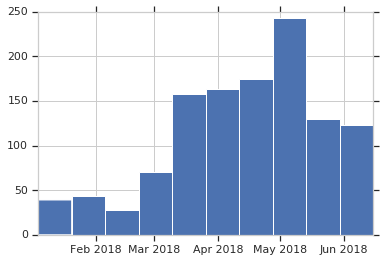

In [140]:
g = plt.hist(x = conversion_per_date.index, weights = conversion_per_date.values)

## Cantidad de conversiones que hay por mes

In [141]:
conversion_per_month = eventos_conversion.month.value_counts()
conversion_per_month

5    351
4    316
3    265
6    103
2     74
1     63
Name: month, dtype: int64

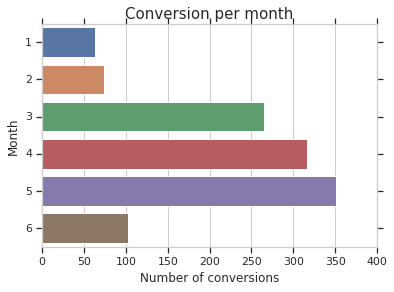

In [142]:
g = sns.barplot(x=conversion_per_month.values, y=conversion_per_month.index, orient='h')
g.set_title("Conversion per month", fontsize=15)
g.set_xlabel("Number of conversions", fontsize=12)
g.set_ylabel("Month", fontsize=12)

Con lo anterior vemos que durante los **meses 3-5** son los que se tuvo más eventos de conversion.

## Cantidad de conversiones según día de la semana y hora

- [ ] TODO! Ordenar weekday por orden de día de la semana, no alfabéticamente.

In [143]:
table = eventos_conversion.pivot_table(index = 'hour', columns = 'weekday', values = 'day', aggfunc = 'count')
table

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
hour,,,,,,,
0,12.00,6.00,6.00,4.00,6.00,14.00,6.00
1,16.00,5.00,6.00,4.00,6.00,10.00,18.00
2,4.00,5.00,6.00,6.00,9.00,13.00,4.00
3,7.00,4.00,8.00,3.00,4.00,12.00,6.00
4,3.00,nan,3.00,1.00,1.00,1.00,3.00
5,2.00,2.00,1.00,3.00,1.00,nan,2.00
6,nan,nan,1.00,nan,1.00,2.00,1.00
7,nan,nan,nan,nan,1.00,2.00,nan
8,1.00,1.00,nan,1.00,1.00,1.00,1.00


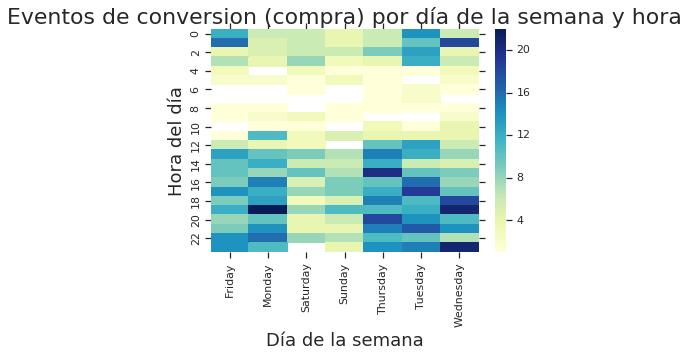

In [144]:
g = sns.heatmap(table,  cmap="YlGnBu")
g.set_title("Eventos de conversion (compra) por día de la semana y hora", fontsize=22)
g.set_xlabel("Día de la semana",fontsize=18)
g.set_ylabel("Hora del día", fontsize=18)

Acá vemos:
- Como se puede esperar dentro de las horas de la mañana 3-11 hay casi nada de actividad.
- Los días de fin de semana hay menos actividad.

## Conversiones según el modelo

In [145]:
# Quiero ver si hay algún nan
print("Cantidad de nans para eventos de compra: " + str(eventos_conversion.model.size - eventos_conversion.model.count()))

Cantidad de nans para eventos de compra: 0


Genial, no hay ningún nan en modelos en los eventos de conversion. No tendría sentido que aparezca alguno.

Veamos los **10 modelos más comúnes en el evento conversion**.
Hay demasiados modelos como para enfocarnos en ver todos los modelos y las distribuciones
de cantidad de veces que aparecen en el evento.

In [146]:
conversion_per_model = eventos_conversion.model.value_counts().head(10)
conversion_per_model

Samsung Galaxy J5         88
iPhone 5s                 84
iPhone 6                  71
Samsung Galaxy S6 Flat    39
iPhone 6S                 37
iPhone 5c                 33
Motorola Moto G3 4G       30
Motorola Moto G4 Plus     30
Samsung Galaxy J7         28
Samsung Galaxy A5         27
Name: model, dtype: int64

In [147]:
eventos_conversion.model.value_counts(normalize = True).head(10)

Samsung Galaxy J5                        0.08
iPhone 5s                                0.07
iPhone 6                                 0.06
Samsung Galaxy S6 Flat                   0.03
iPhone 6S                                0.03
iPhone 5c                                0.03
Motorola Moto G3 4G                      0.03
Motorola Moto G4 Plus                    0.03
Samsung Galaxy J7                        0.02
Samsung Galaxy A5                        0.02
Name: model, dtype: float64

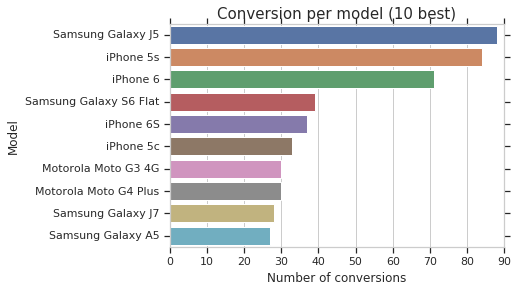

In [148]:
g = sns.barplot(x=conversion_per_model.values, y=conversion_per_model.index, orient='h')
g.set_title("Conversion per model (10 best)", fontsize=15)
g.set_xlabel("Number of conversions", fontsize=12)
g.set_ylabel("Model", fontsize=12)

Vemos que los tres primeros difieren por bastante de los otros.
De hecho el cuarto mejor aparece un poco más de la mitad de veces que el tercero.
Y viendo los porcentajes el cuarto está con un 30%, mientras que el tercero llega al 60% ya.

# Análisis por características de celulares

## Storage

In [151]:
check_out_per_storage = eventos_check_out.storage.value_counts()
check_out_per_storage

16GB     12462
32GB      9729
64GB      5436
8GB       3638
128GB     1840
4GB        295
256GB      270
512MB       63
Name: storage, dtype: int64

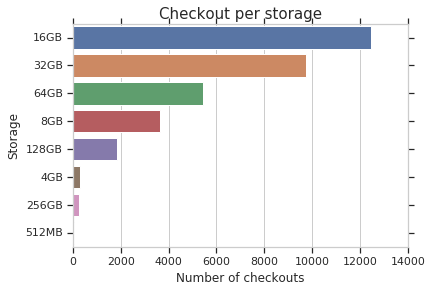

In [152]:
g = sns.barplot(x=check_out_per_storage.values, y=check_out_per_storage.index, orient='h')
g.set_title("Checkout per storage", fontsize=15)
g.set_xlabel("Number of checkouts", fontsize=12)
g.set_ylabel("Storage", fontsize=12)

In [153]:
conversion_per_storage = eventos_conversion.storage.value_counts()
conversion_per_storage

16GB     552
32GB     265
8GB      205
64GB     102
128GB     27
4GB       17
512MB      3
256GB      1
Name: storage, dtype: int64

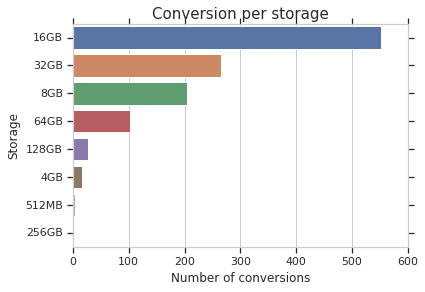

In [154]:
g = sns.barplot(x=conversion_per_storage.values, y=conversion_per_storage.index, orient='h')
g.set_title("Conversion per storage", fontsize=15)
g.set_xlabel("Number of conversions", fontsize=12)
g.set_ylabel("Storage", fontsize=12)

In [158]:
viewed_product_per_storage = eventos_viewed_product.storage.value_counts()
viewed_product_per_storage

16GB     177819
32GB     174461
64GB      94486
128GB     38938
8GB       34338
256GB      6550
4GB        1840
512MB       499
Name: storage, dtype: int64

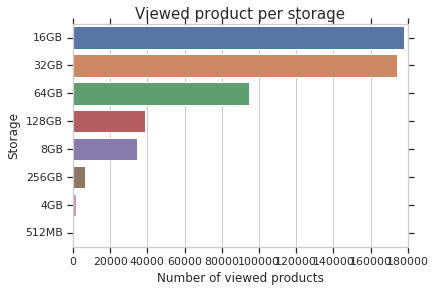

In [159]:
g = sns.barplot(x=viewed_product_per_storage.values, y=viewed_product_per_storage.index, orient='h')
g.set_title("Viewed product per storage", fontsize=15)
g.set_xlabel("Number of viewed products", fontsize=12)
g.set_ylabel("Storage", fontsize=12)

## Condition

In [160]:
conversion_per_condition = eventos_conversion.condition.value_counts()
conversion_per_condition

Bom                   538
Muito Bom             352
Excelente             258
Bom - Sem Touch ID     22
Novo                    2
Name: condition, dtype: int64

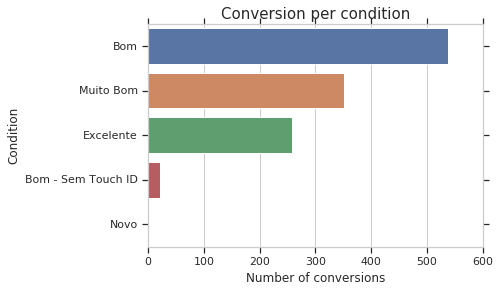

In [161]:
g = sns.barplot(x=conversion_per_condition.values, y=conversion_per_condition.index, orient='h')
g.set_title("Conversion per condition", fontsize=15)
g.set_xlabel("Number of conversions", fontsize=12)
g.set_ylabel("Condition", fontsize=12)

In [162]:
check_out_per_condition = eventos_check_out.condition.value_counts()
check_out_per_condition

Bom                   15305
Excelente              9141
Muito Bom              8184
Bom - Sem Touch ID     1090
Novo                     13
Name: condition, dtype: int64

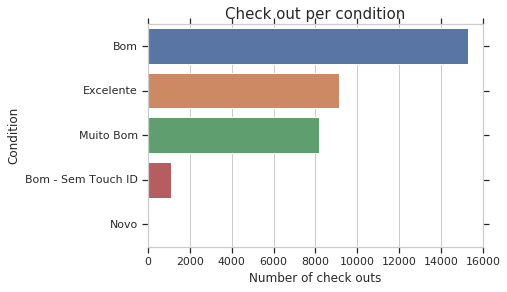

In [163]:
g = sns.barplot(x=check_out_per_condition.values, y=check_out_per_condition.index, orient='h')
g.set_title("Check out per condition", fontsize=15)
g.set_xlabel("Number of check outs", fontsize=12)
g.set_ylabel("Condition", fontsize=12)

In [164]:
viewed_product_per_condition = eventos_viewed_product.condition.value_counts()
viewed_product_per_condition

Bom                   227171
Excelente             143578
Muito Bom             142823
Bom - Sem Touch ID     14183
Novo                    1176
Name: condition, dtype: int64

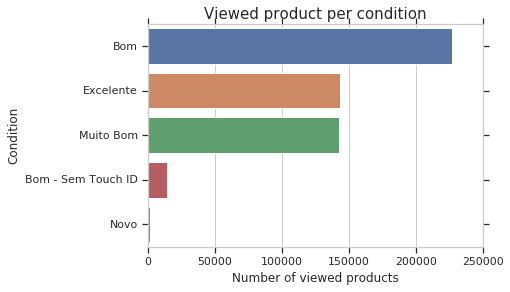

In [165]:
g = sns.barplot(x=viewed_product_per_condition.values, y=viewed_product_per_condition.index, orient='h')
g.set_title("Viewed product per condition", fontsize=15)
g.set_xlabel("Number of viewed products", fontsize=12)
g.set_ylabel("Condition", fontsize=12)

# Conversion por colores del modelo más frecuente

Un análisis aburrida que hice en unos minutos libres y sin ideas.

In [166]:
conversion_per_color = eventos_conversion.color.value_counts()
conversion_per_color

Preto              368
Dourado            269
Branco             216
Cinza espacial      89
Prateado            51
Ouro Rosa           32
Rosa                30
Cinza               23
Azul                22
Preto Vermelho      11
Prata                8
Platinum             7
Branco Vermelho      6
Preto Matte          6
Verde                5
Ametista             4
Titânio              4
Ouro                 4
Preto Brilhante      3
Indigo               3
Bambu                2
Cabernet             2
Vermelho             2
Amarelo              2
Preto Azul           1
Couro Vintage        1
Azul Topázio         1
Name: color, dtype: int64

Fijemosnos en los 5 primeros, que son los que tienen mayor porcentaje.

In [167]:
conversion_per_color = conversion_per_color.head(5)

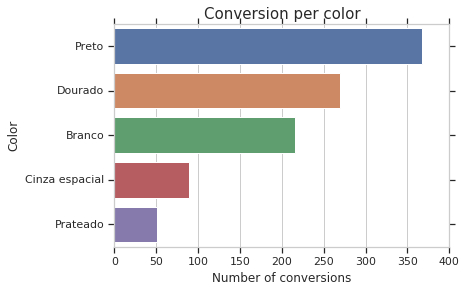

In [168]:
g = sns.barplot(x=conversion_per_color.values, y=conversion_per_color.index, orient='h')
g.set_title("Conversion per color", fontsize=15)
g.set_xlabel("Number of conversions", fontsize=12)
g.set_ylabel("Color", fontsize=12)

In [169]:
# Esto no es muy interesante realmente, tal vez con más de los "mejores" modelos sea más interesante.
# Igual, no se que tanto aporta.

conversion_per_color = eventos_conversion.loc[eventos_conversion.model == 'Samsung Galaxy J5'].color.value_counts().head(10)
conversion_per_color

Dourado    52
Preto      21
Branco     15
Name: color, dtype: int64

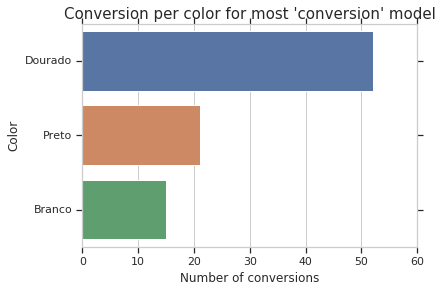

In [170]:
g = sns.barplot(x=conversion_per_color.values, y=conversion_per_color.index, orient='h')
g.set_title("Conversion per color for most 'conversion' model", fontsize=15)
g.set_xlabel("Number of conversions", fontsize=12)
g.set_ylabel("Color", fontsize=12)

# Análisis de los eventos de *'search\_engine\_hit'*

In [171]:
eventos_search_engine_hit = eventos_raw.loc[eventos_raw.event == 'search engine hit']
eventos_search_engine_hit.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,device_type,screen_resolution,operating_system_version,browser_version,year,month,day,weekday,hour,dia_semana
10,2018-04-09 20:12:31,search engine hit,000a54b2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2018,4,9,Monday,20,Domingo
17,2018-05-24 11:21:07,search engine hit,000a54b2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2018,5,24,Thursday,11,Miércoles
47,2018-04-06 05:12:05,search engine hit,00184bf9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2018,4,6,Friday,5,Jueves
62,2018-04-06 05:12:59,search engine hit,00184bf9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2018,4,6,Friday,5,Jueves
97,2018-05-17 00:08:56,search engine hit,0019c395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2018,5,17,Thursday,0,Miércoles


In [172]:
eventos_search_engine_hit.columns

Index(['timestamp', 'event', 'person', 'url', 'sku', 'model', 'condition',
       'storage', 'color', 'skus', 'search_term', 'staticpage',
       'campaign_source', 'search_engine', 'channel', 'new_vs_returning',
       'city', 'region', 'country', 'device_type', 'screen_resolution',
       'operating_system_version', 'browser_version', 'year', 'month', 'day',
       'weekday', 'hour', 'dia_semana'],
      dtype='object')

In [173]:
# Google lleva la delantera. (?)

search_engine = eventos_search_engine_hit.search_engine.value_counts()
search_engine

Google    50240
Bing        424
Yahoo       287
Ask           6
Name: search_engine, dtype: int64

In [174]:
# Vemos que el 99% de los search engine hit se hacen a traves de Google.
# Sinceramente no es algo que no hubiesemos esperado.

search_engine_normalize = eventos_search_engine_hit.search_engine.value_counts(normalize=True)
search_engine_normalize

Google                   0.99
Bing                     0.01
Yahoo                    0.01
Ask                      0.00
Name: search_engine, dtype: float64

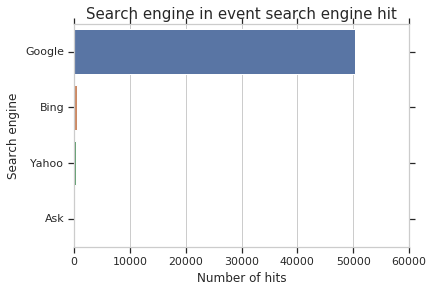

In [175]:
g = sns.barplot(x=search_engine.values, y=search_engine.index, orient='h')
g.set_title("Search engine in event search engine hit", fontsize=15)
g.set_xlabel("Number of hits", fontsize=12)
g.set_ylabel("Search engine", fontsize=12)

# Sí, un gráfico sin mucho sentido.

## Search engine hit por mes

In [176]:
search_engine_hit_per_month = eventos_search_engine_hit.month.value_counts()
search_engine_hit_per_month

5    24259
6    15429
4     5641
3     3287
2     1338
1     1003
Name: month, dtype: int64

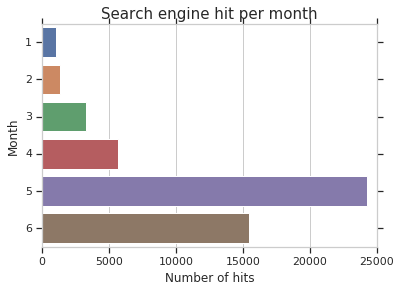

In [177]:
# Vemos que tenemos más en los meses 5, y 6 aunque menos.

g = sns.barplot(x=search_engine_hit_per_month.values, y=search_engine_hit_per_month.index, orient='h')
g.set_title("Search engine hit per month", fontsize=15)
g.set_xlabel("Number of hits", fontsize=12)
g.set_ylabel("Month", fontsize=12)

A esta altura deben de estar artos de mis gráficos de barra. :/ **buu**

# Análisis según el tipo de dispositivo que usa el usuario

In [178]:
## eventos_raw.device_type.value_counts()

In [179]:
# Está miti miti entre smartphone y computer.
# La diferencia del device con el que ven los productos puede hacer que por la calidad de
# como se ve cambie el si compran o no, o qué compran. También qué tanto se quedan
# en la página buscando y viendo productos.

eventos_raw.device_type.value_counts(normalize = True)

Smartphone                   0.51
Computer                     0.48
Tablet                       0.01
Unknown                      0.00
Name: device_type, dtype: float64

In [180]:
groupby_person_day = eventos_raw.groupby(['person', 'day'])
groupby_person_day

In [181]:
# Relación: cuantos productos ve un usuario hasta decidir cual comprar.

In [182]:
groupby_person_day.event.value_counts().head()

person    day  event          
0004b0a2  31   ad campaign hit    1
               checkout           1
               viewed product     1
               visited site       1
0006a21a  29   ad campaign hit    1
Name: event, dtype: int64

In [183]:
# Acá quería ver la cantidad de horas seguidas que está un usuario en la página.
# Y relacionarlo con el tipo de dispositivo que estuvieron usando.
#groupby_person_day.hour.max() - groupby_person_day.hour.min()

# Análisis con el evento *'check-out'*

In [184]:
eventos_check_out = eventos_raw.loc[eventos_raw.event == 'checkout']
eventos_check_out.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,device_type,screen_resolution,operating_system_version,browser_version,year,month,day,weekday,hour,dia_semana
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,2018,5,31,Thursday,23,Miércoles
7,2018-05-29 13:29:35,checkout,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,2018,5,29,Tuesday,13,Lunes
44,2018-05-24 11:34:32,checkout,000a54b2,NaN,12660.0,Motorola Moto Z Play,Bom,32GB,Preto,NaN,...,NaN,NaN,NaN,NaN,2018,5,24,Thursday,11,Miércoles
85,2018-04-06 05:14:58,checkout,00184bf9,NaN,6355.0,Samsung Galaxy J5,Excelente,16GB,Preto,NaN,...,NaN,NaN,NaN,NaN,2018,4,6,Friday,5,Jueves
86,2018-04-06 05:18:15,checkout,00184bf9,NaN,6355.0,Samsung Galaxy J5,Excelente,16GB,Preto,NaN,...,NaN,NaN,NaN,NaN,2018,4,6,Friday,5,Jueves


## Cantidad de checkouts durante el año

In [186]:
check_out_per_date = eventos_check_out.timestamp.dt.date.value_counts()
check_out_per_date.head()

2018-06-05    1177
2018-06-06    1078
2018-06-04    1071
2018-05-29    1062
2018-06-14    1031
Name: timestamp, dtype: int64

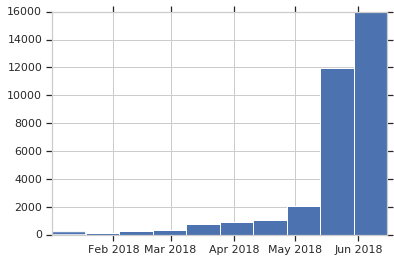

In [188]:
g = plt.hist(x = check_out_per_date.index, weights = check_out_per_date.values)

## Checkouts por mes

In [62]:
check_out_per_month = eventos_check_out.month.value_counts()
check_out_per_month

5    15645
6    13967
4     1965
3     1386
2      441
1      331
Name: month, dtype: int64

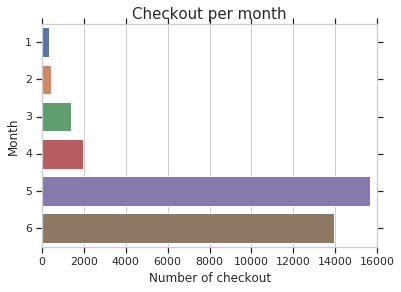

In [63]:
g = sns.barplot(x=check_out_per_month.values, y=check_out_per_month.index, orient='h')
g.set_title("Checkout per month", fontsize=15)
g.set_xlabel("Number of checkout", fontsize=12)
g.set_ylabel("Month", fontsize=12)

## Checkouts según día de la semana y hora

In [64]:
table = eventos_check_out.pivot_table(index = 'hour', columns = 'weekday', values = 'day', aggfunc = 'count')
table

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
hour,,,,,,,
0,333,218,266,186,333,373,326
1,295,181,238,186,327,359,338
2,233,164,192,162,271,296,231
3,179,86,145,123,159,181,175
4,107,60,72,80,103,101,102
5,47,44,61,50,47,64,49
6,46,24,21,27,38,31,41
7,25,16,19,24,25,27,17
8,23,15,19,28,27,25,30


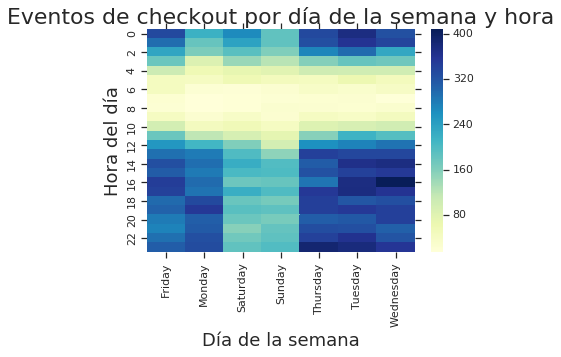

In [65]:
g = sns.heatmap(table,  cmap="YlGnBu")
g.set_title("Eventos de checkout por día de la semana y hora", fontsize=22)
g.set_xlabel("Día de la semana",fontsize=18)
g.set_ylabel("Hora del día", fontsize=18)

# Viewed product

In [157]:
eventos_viewed_product = eventos_raw.loc[eventos_raw.event == 'viewed product']
eventos_viewed_product.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,device_type,screen_resolution,operating_system_version,browser_version,year,month,day,weekday,hour,dia_semana
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,2018,5,31,Thursday,23,Miércoles
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,2018,5,29,Tuesday,13,Lunes
13,2018-04-09 20:13:14,viewed product,000a54b2,NaN,12661.0,Motorola Moto Z Play,Muito Bom,32GB,Preto,NaN,...,NaN,NaN,NaN,NaN,2018,4,9,Monday,20,Domingo
22,2018-05-24 11:27:47,viewed product,000a54b2,NaN,10254.0,iPhone 7 Plus,Excelente,256GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,2018,5,24,Thursday,11,Miércoles
26,2018-05-24 11:28:59,viewed product,000a54b2,NaN,6581.0,iPhone 6S,Bom,16GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,2018,5,24,Thursday,11,Miércoles


In [67]:
viewed_product_per_model = eventos_viewed_product.model.value_counts().head(10)
viewed_product_per_model

iPhone 6                  47538
iPhone 5s                 42045
iPhone 6S                 36930
iPhone 7                  26330
Samsung Galaxy S7 Edge    23062
Samsung Galaxy S7         18085
iPhone 7 Plus             17853
iPhone SE                 15874
Samsung Galaxy S8         15868
iPhone 6S Plus            12250
Name: model, dtype: int64

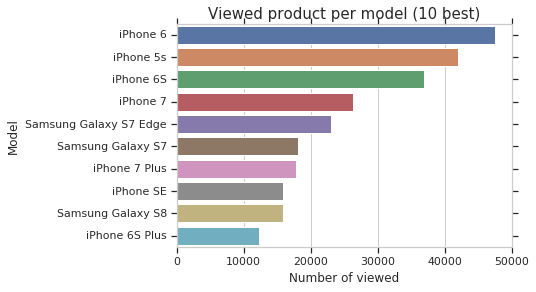

In [68]:
g = sns.barplot(x=viewed_product_per_model.values, y=viewed_product_per_model.index, orient='h')
g.set_title("Viewed product per model (10 best)", fontsize=15)
g.set_xlabel("Number of viewed", fontsize=12)
g.set_ylabel("Model", fontsize=12)

- [ ] TODO: hacer un scatter plot superponiendo el gráfico de compras por modelo y de vistas por modelo.
            Habría que pensar en que en ambos aparecen modelos diferentes (tal vez).

- Quiero ver por device type y persona cuantas veces se tiene el evento viewed_product.
  Contar cuantas veces por persona para sacar un promedio de cuantos de esos eventos se
  tienen para cada tipo de dispositivo desde donde se ve.

In [69]:
#eventos_raw['computer'] = eventos_raw.device_type == 'Computer'
#eventos_raw['smartphone'] = eventos_raw.device_type == 'Smartphone'

In [70]:
eventos_raw.groupby(['event','person' , 'device_type']).hour.count()

event         person    device_type
visited site  0004b0a2  Smartphone      1
              0006a21a  Smartphone      1
              000a54b2  Computer        2
              00184bf9  Computer        2
              0019c395  Smartphone      1
              001bb7eb  Computer        2
              001f1653  Smartphone      1
              00204059  Computer       12
              0024a82b  Computer        1
              0024ad28  Computer        3
              00269e77  Smartphone      4
              0026fd72  Computer        2
              0027c344  Computer        3
              00283a9e  Smartphone      2
              002932b1  Smartphone      4
              002cecfa  Computer        1
              00300ace  Computer        2
              00344c0a  Computer        1
              003857f6  Computer        7
              003f561a  Smartphone      2
              003ff6cd  Computer        3
              00420f4e  Smartphone      4
              0047c5c6  Computer        

In [71]:
eventos_raw.groupby(['person','event']).hour.value_counts()

person    event              hour
0004b0a2  ad campaign hit    23       1
          checkout           23       1
          viewed product     23       1
          visited site       23       1
0006a21a  ad campaign hit    13       1
          checkout           13       1
          viewed product     13       1
          visited site       13       1
000a54b2  ad campaign hit    11       1
                             20       1
          brand listing      11       4
                             20       2
          checkout           11       1
          generic listing    11       4
                             20       1
          search engine hit  11       1
                             20       1
          viewed product     11      18
                             20       1
          visited site       11       1
                             20       1
00184bf9  brand listing      5        5
                             18       2
          checkout           5        2
      

In [72]:
eventos_raw.columns

Index(['timestamp', 'event', 'person', 'url', 'sku', 'model', 'condition',
       'storage', 'color', 'skus', 'search_term', 'staticpage',
       'campaign_source', 'search_engine', 'channel', 'new_vs_returning',
       'city', 'region', 'country', 'device_type', 'screen_resolution',
       'operating_system_version', 'browser_version', 'year', 'month', 'day',
       'weekday', 'hour'],
      dtype='object')

In [73]:
channels = eventos_raw.channel.value_counts()
channels

Paid        44193
Direct      18522
Organic     12348
Referral    11384
Social        846
Email          76
Unknown         9
Name: channel, dtype: int64

In [74]:
eventos_raw.channel.value_counts(normalize = True)

Paid                       0.51
Direct                     0.21
Organic                    0.14
Referral                   0.13
Social                     0.01
Email                      0.00
Unknown                    0.00
Name: channel, dtype: float64

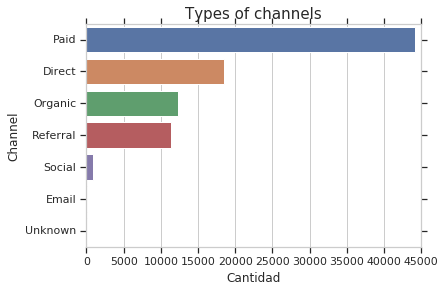

In [75]:
g = sns.barplot(x=channels.values, y=channels.index, orient='h')
g.set_title("Types of channels", fontsize=15)
g.set_xlabel("Cantidad", fontsize=12)
g.set_ylabel("Channel", fontsize=12)

- Casi la mitad de los channels vienen de paid (campaña paga).

In [76]:
eventos_lead = eventos_raw.loc[eventos_raw.event == 'lead']
eventos_lead.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448 entries, 3248 to 1003073
Data columns (total 28 columns):
timestamp                   448 non-null datetime64[ns]
event                       448 non-null object
person                      448 non-null object
url                         0 non-null object
sku                         0 non-null object
model                       448 non-null object
condition                   0 non-null object
storage                     0 non-null object
color                       0 non-null object
skus                        0 non-null object
search_term                 0 non-null object
staticpage                  0 non-null object
campaign_source             0 non-null object
search_engine               0 non-null object
channel                     0 non-null object
new_vs_returning            0 non-null object
city                        0 non-null object
region                      0 non-null object
country                     0 non-null objec

In [77]:
lead_per_model = eventos_lead.model.value_counts().head(10)
lead_per_model

iPhone 6 Plus                 35
iPhone 6S Plus                31
Samsung Galaxy J7 Prime       26
iPhone 6S                     21
Motorola Moto G4 Plus         20
iPhone 8                      20
Motorola Moto G5 Plus         15
Samsung Galaxy A9 Pro 2016    15
Samsung Galaxy On 7           15
LG K10 Novo                   12
Name: model, dtype: int64

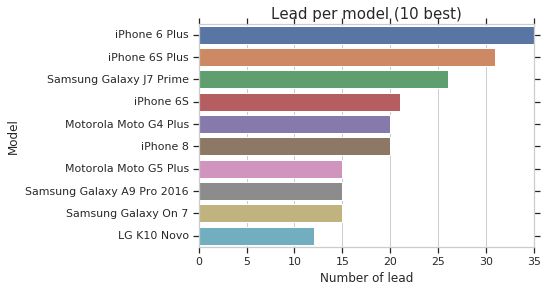

In [78]:
g = sns.barplot(x=lead_per_model.values, y=lead_per_model.index, orient='h')
g.set_title("Lead per model (10 best)", fontsize=15)
g.set_xlabel("Number of lead", fontsize=12)
g.set_ylabel("Model", fontsize=12)

- Las conclusiones que podemos sacar de ver el evento lead no son fiables, ya que podemos llegar a comparar la
  cantidad de leads por modelo y compararlo con la cantidad de conversiones o checkouts, para ver que tanto
  sobrepasa la demanda a la oferta. Pero la verdad es que este dato no sabemos si tiene una concordancia
  confiable con la realidad, ya que generalmente la mayor parte de la gente que encuentra que el 
  producto que buscó no está en la página se va a buscarlo a otros lados, no se preocupa por pedir un lead.
- Sí se puede ver relación entre la cantidad de leads que se hacen de la cantidad de checkouts sin 
  que se efectue realmente la conversión. Aunque devuelta no confiaría mucho en lo que nos diga esto.

In [79]:
eventos_searched_products = eventos_raw.loc[eventos_raw.event == 'searched products']
eventos_searched_products.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,country,device_type,screen_resolution,operating_system_version,browser_version,year,month,day,weekday,hour
157,2018-02-06 02:29:49,searched products,00204059,NaN,NaN,NaN,NaN,NaN,NaN,"2692,6819,823,2779,13864,2784,8135,6805,2773,2...",...,NaN,NaN,NaN,NaN,NaN,2018,2,6,Tuesday,2
159,2018-02-06 02:32:41,searched products,00204059,NaN,NaN,NaN,NaN,NaN,NaN,"2692,6819,823,2779,13864,2784,8135,6805,2773,2...",...,NaN,NaN,NaN,NaN,NaN,2018,2,6,Tuesday,2
238,2018-05-21 19:56:33,searched products,0024ad28,NaN,NaN,NaN,NaN,NaN,NaN,"3371,6357,6371,10896,2718,2777,6001,2694,3191,...",...,NaN,NaN,NaN,NaN,NaN,2018,5,21,Monday,19
239,2018-05-21 19:57:28,searched products,0024ad28,NaN,NaN,NaN,NaN,NaN,NaN,"3371,6357,6371,10896,2718,2777,6001,2694,3191,...",...,NaN,NaN,NaN,NaN,NaN,2018,5,21,Monday,19
240,2018-05-21 19:57:49,searched products,0024ad28,NaN,NaN,NaN,NaN,NaN,NaN,"3371,6357,6371,10896,2718,2777,6001,2694,3191,...",...,NaN,NaN,NaN,NaN,NaN,2018,5,21,Monday,19


In [80]:
eventos_searched_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56073 entries, 157 to 1011280
Data columns (total 28 columns):
timestamp                   56073 non-null datetime64[ns]
event                       56073 non-null object
person                      56073 non-null object
url                         0 non-null object
sku                         0 non-null object
model                       0 non-null object
condition                   0 non-null object
storage                     0 non-null object
color                       0 non-null object
skus                        55954 non-null object
search_term                 48967 non-null object
staticpage                  0 non-null object
campaign_source             0 non-null object
search_engine               0 non-null object
channel                     0 non-null object
new_vs_returning            0 non-null object
city                        0 non-null object
region                      0 non-null object
country                     0 n

In [81]:
eventos_searched_products = eventos_searched_products.dropna(axis = 1, how = 'all')
eventos_searched_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56073 entries, 157 to 1011280
Data columns (total 10 columns):
timestamp      56073 non-null datetime64[ns]
event          56073 non-null object
person         56073 non-null object
skus           55954 non-null object
search_term    48967 non-null object
year           56073 non-null int64
month          56073 non-null int64
day            56073 non-null int64
weekday        56073 non-null object
hour           56073 non-null int64
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 4.7+ MB


In [82]:
# Mando todo a minúsculas para juntar los mismos términos, sin distinción de case (no nos sirven separados)
search_terms = eventos_searched_products.search_term.str.lower().value_counts()
search_terms.head()

iphone 6     3347
iphone       2968
iphone 6s    2576
iphone 7     1354
iphone 5s    1101
Name: search_term, dtype: int64

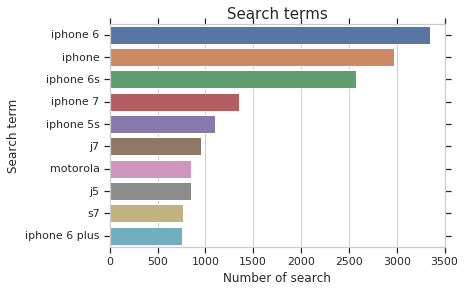

In [83]:
g = sns.barplot(x=search_terms.head(10).values, y=search_terms.head(10).index, orient='h')
g.set_title("Search terms", fontsize=15)
g.set_xlabel("Number of search", fontsize=12)
g.set_ylabel("Search term", fontsize=12)

- Todos los más buscados son de iphones, tiene sentido después de todo también fueron de los que más
  de viewed product tuvieron. Aunque no son de los que más se compraron al final.

- [ ] TODO: podríamos tratar de filtrar algunos términos especiales que se repiten en la mayoría de las
            busquedas. Como cuando buscan iphones, samsungs (por marca/modelo). También si se buscan
            cosas específicas como la cantidad de almacenamiento, si buscan usados/seminovos
            y demases características.

Quiero ver cuanta si hay una clase de "perdida" entre sku y skus (debería de ser igual) 

In [84]:
sku = eventos_raw.sku.dropna().unique()
sku

array(['2694.0', '15338.0', '12661.0', ..., '8357', '893', '8372'], dtype=object)

In [85]:
skus = eventos_raw.skus.dropna().str.split(",", expand = True)
skus.head()

,0,1,2,3,4,5,6,7,8,9,10,11
8,10310,13333,13347,9902,9944,12774,12801,12744,12732,12758,9022,4045
12,5075,12536,12520,12661,12506,12549,10449,9175,9218,7825,2929,8567
14,5075,12536,12520,12661,12506,12549,10449,9175,9218,7825,2929,8567
18,6649,7237,2820,2750,6707,6720,7224,12619,12605,2766,11346,2774
19,6649,7237,2820,2750,6707,6720,7224,12619,12605,2766,11346,2774


In [86]:
skus_serie = pd.Series() 
skus_serie

Series([], dtype: float64)

In [87]:
def append_all_columns(dataframe):
    serie = pd.Series()
    for n in dataframe.columns:
        serie = serie.append(dataframe[n])
    return serie

skus_serie = append_all_columns(skus).dropna()

In [88]:
pd.Series(skus_serie.dropna().unique()).count()

1821

In [89]:
sku_serie = pd.Series(sku)

In [90]:
sku_serie.count()

3574

# Análisis por marca

In [153]:
marcas = eventos_raw.model.dropna().str.partition(' ')[0].unique()
marcas

array(['iPhone', 'Samsung', 'Motorola', 'Asus', 'Quantum', 'Lenovo',
       'Sony', 'LG', 'iPad', 'Blackberry'], dtype=object)